# Crop Type Classification - Data Cleaning and visualization

This notebook illustrates the process of cleaning, preprocessing, and visualizing Normalized Difference Vegetation Index (NDVI) signature data. The resulting NDVI timeseries serves as input for training a crop type classification model in subsequent notebooks within this directory.

Outliers rejected by this workflow can be termed as non crop data. 

### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda create --name 'env_name' --file requirements.txt
$ conda activate 'env_name'
```

### Key Libraries:

- [Geopandas](https://geopandas.org/en/stable/docs.html), [Pandas]((https://xgboost.readthedocs.io/en/stable/)): Data handling and manipulation.
- [Matplotlib](https://matplotlib.org/stable/index.html): Utilized for data visualization.

### Meta Data information
- Crop types: Wheat, Mustard & Potato
- Time period recorded: fy 2022-23 (oct-22 to apr-23)
- Location: Madhya Pradesh, Uttar Pradesh
- Source: [Bhuvan Fasal(via MNCFC)](https://ncfc.gov.in/downloads/apps_update/FASAL_GT_CCE%20_Userguidelines.pdf) for Ground Truth and [Sentinel 2(via Google earth Engine)](https://developers.google.com/earth-engine/datasets/catalog/sentinel-2) for NDVI.

This workflow is performed on crop field data belonging to wheat, mustard and potato crops only (Bhuvan Fasal). However the same process can be extended to other crops grown in the Rabi season.

--------

# Imports

In [1]:
# Changing working dir to the repository main folder
import os
try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-2]))
    kernel_is_loaded = True

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import random

pd.options.display.max_columns = 30

import warnings
warnings.filterwarnings("ignore")

# Seeding
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Initial Preprocessing

In [2]:
# Importing the data sample

data_path = 'notebooks/demo/data_files/raw_data_sample.csv'

raw_data= pd.read_csv(data_path)

display(raw_data.head(5), raw_data.shape)

,geometry,date,state,district,tehsil,oct_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,apr_2f,crop_type
0,POINT (76.5864473 23.0626127),2022-10-01,Madhya Pradesh,Sehore,Ashta,135.0,136.0,129.0,160.0,181.0,188.0,189.0,186.0,185.0,157.0,149.0,123.0,129.0,125.0,Wheat
1,POINT (80.75275775920343 28.123783079674084),2022-10-01,Madhya Pradesh,Shivpuri,Karera,174.0,144.0,132.0,137.0,168.0,196.0,192.0,189.0,189.0,177.0,163.0,134.0,121.0,116.0,Wheat
2,POINT (80.6953146 24.6439101),2022-10-01,Madhya Pradesh,Satna,Raghurajnagar,154.0,150.0,126.0,132.0,155.0,169.0,180.0,182.0,181.0,175.0,151.0,122.0,115.0,114.0,Wheat
3,POINT (77.9981737 22.8078004),2022-10-01,Madhya Pradesh,Hoshangabad,Babai,180.0,171.0,135.0,128.0,135.0,162.0,178.0,173.0,185.0,188.0,175.0,144.0,134.0,130.0,Wheat
4,POINT (76.0541291 23.1204061),2022-10-01,Madhya Pradesh,Ujjain,Dewas,142.0,123.0,119.0,120.0,148.0,183.0,191.0,188.0,192.0,189.0,153.0,127.0,117.0,117.0,Wheat


(360, 20)

In [97]:
# Removing redundant columns and reorganizing and formatting essential ones.
necessary_features = ['oct_1f', 'oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 
                        'feb_1f', 'feb_2f', 'mar_1f', 'mar_2f', 'apr_1f', 'apr_2f', 'crop_type']

data = raw_data.loc[:,necessary_features]

display(data.head(5), data.shape)

,oct_1f,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,apr_2f,crop_type
0,135.0,136.0,129.0,160.0,181.0,188.0,189.0,186.0,185.0,157.0,149.0,123.0,129.0,125.0,Wheat
1,174.0,144.0,132.0,137.0,168.0,196.0,192.0,189.0,189.0,177.0,163.0,134.0,121.0,116.0,Wheat
2,154.0,150.0,126.0,132.0,155.0,169.0,180.0,182.0,181.0,175.0,151.0,122.0,115.0,114.0,Wheat
3,180.0,171.0,135.0,128.0,135.0,162.0,178.0,173.0,185.0,188.0,175.0,144.0,134.0,130.0,Wheat
4,142.0,123.0,119.0,120.0,148.0,183.0,191.0,188.0,192.0,189.0,153.0,127.0,117.0,117.0,Wheat


(360, 15)

## Data cleaning and EDA

__Imputing NDVI readings masked by the clouds__

- If there is a significant drop of more than 20 in NDVI values for a specific fortnight, we impute the values using the average of neighboring fortnights.  

In [98]:
def dip_impute(row):
    lst = deepcopy(row)
    act_strt_idx = lst.index.get_loc('oct_2f')
    for i in range(len(lst.loc['oct_2f':'apr_1f'])):
        actual_idx = i + act_strt_idx
        if ((lst.iloc[actual_idx-1] - lst.iloc[actual_idx]) >= 20) and ((lst.iloc[actual_idx+1] - lst.iloc[actual_idx]) >= 20):
            lst.iloc[actual_idx] = (lst.iloc[actual_idx-1] + lst.iloc[actual_idx+1])/2
    return lst

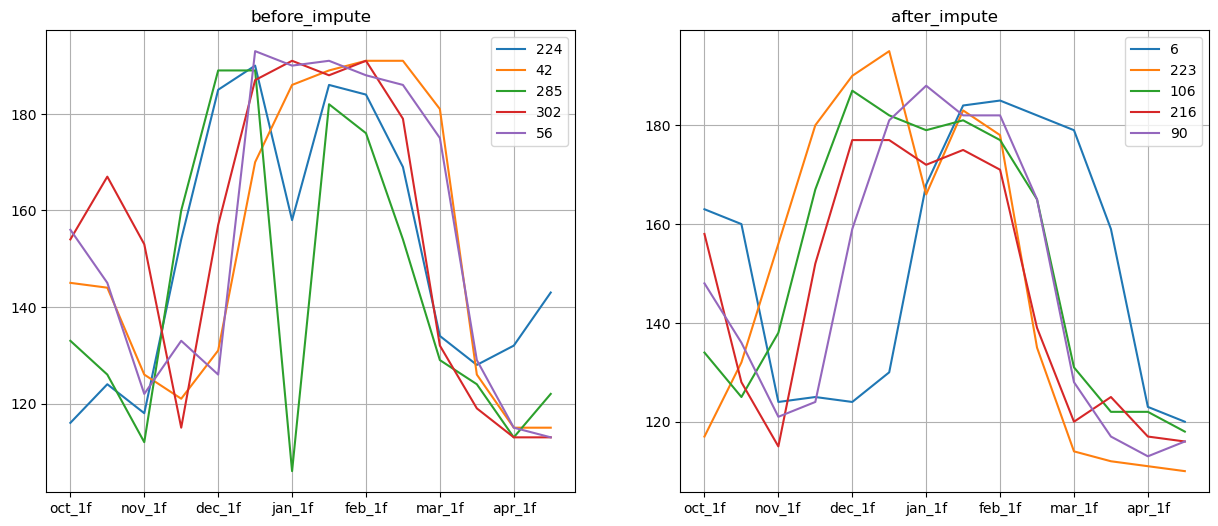

In [99]:
# If there is a significant drop of more than 20 in NDVI values for a specific fortnight, we impute the values using the average of neighboring fortnights.

before_impute = data.loc[:,'oct_1f':'apr_2f'].sample(5, random_state=42)
data = data.apply(dip_impute, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

before_impute.T.plot(ax=axes[0],title='before_impute')
data.loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[1],title='after_impute')
plt.show()

__Determination of sowing period__

 - Find the global minima of the time series containing scaled NDVI values ((NDVI *100)+100) from the 6 possible fortnights of rabi season. 
 - The chosen minima should have a value between 110-140.
 - The successor of minima should have a slope of > 5.
 - The fourth successive point from the minima should have a positive slope w.r.t the successor.
 - If the minima satisfies 2,3 and 4 points then it is considered to be the sowing period of the crop else consider the successive NDVI as the new probable sowing period and repeat the process.


In [100]:
# Sowing period determination

def sowing_period(row):
    sowing_periods = row.loc['oct_1f':'dec_2f'].index
    sowing_periods_NDVI = row.loc['oct_1f':'dec_2f']
    minima = np.argmin(sowing_periods_NDVI)
    ndvi_values = row.loc['oct_1f':'apr_2f']
    i = minima
    while i < len(sowing_periods):
        if ndvi_values.iloc[i] in set(np.arange(110, 141)):
            if (ndvi_values.iloc[i+1] - ndvi_values.iloc[i]) > 5:
                if ((ndvi_values.iloc[i+1] - ndvi_values.iloc[i+4]) < 30):
                    return sowing_periods[i]
        i += 1 
    return 'Unknown'

data['sowing_period'] = data.apply(sowing_period, axis=1)

data.sowing_period.value_counts()

nov_1f     138
nov_2f      65
oct_2f      60
dec_1f      44
oct_1f      25
Unknown     20
dec_2f       8
Name: sowing_period, dtype: int64

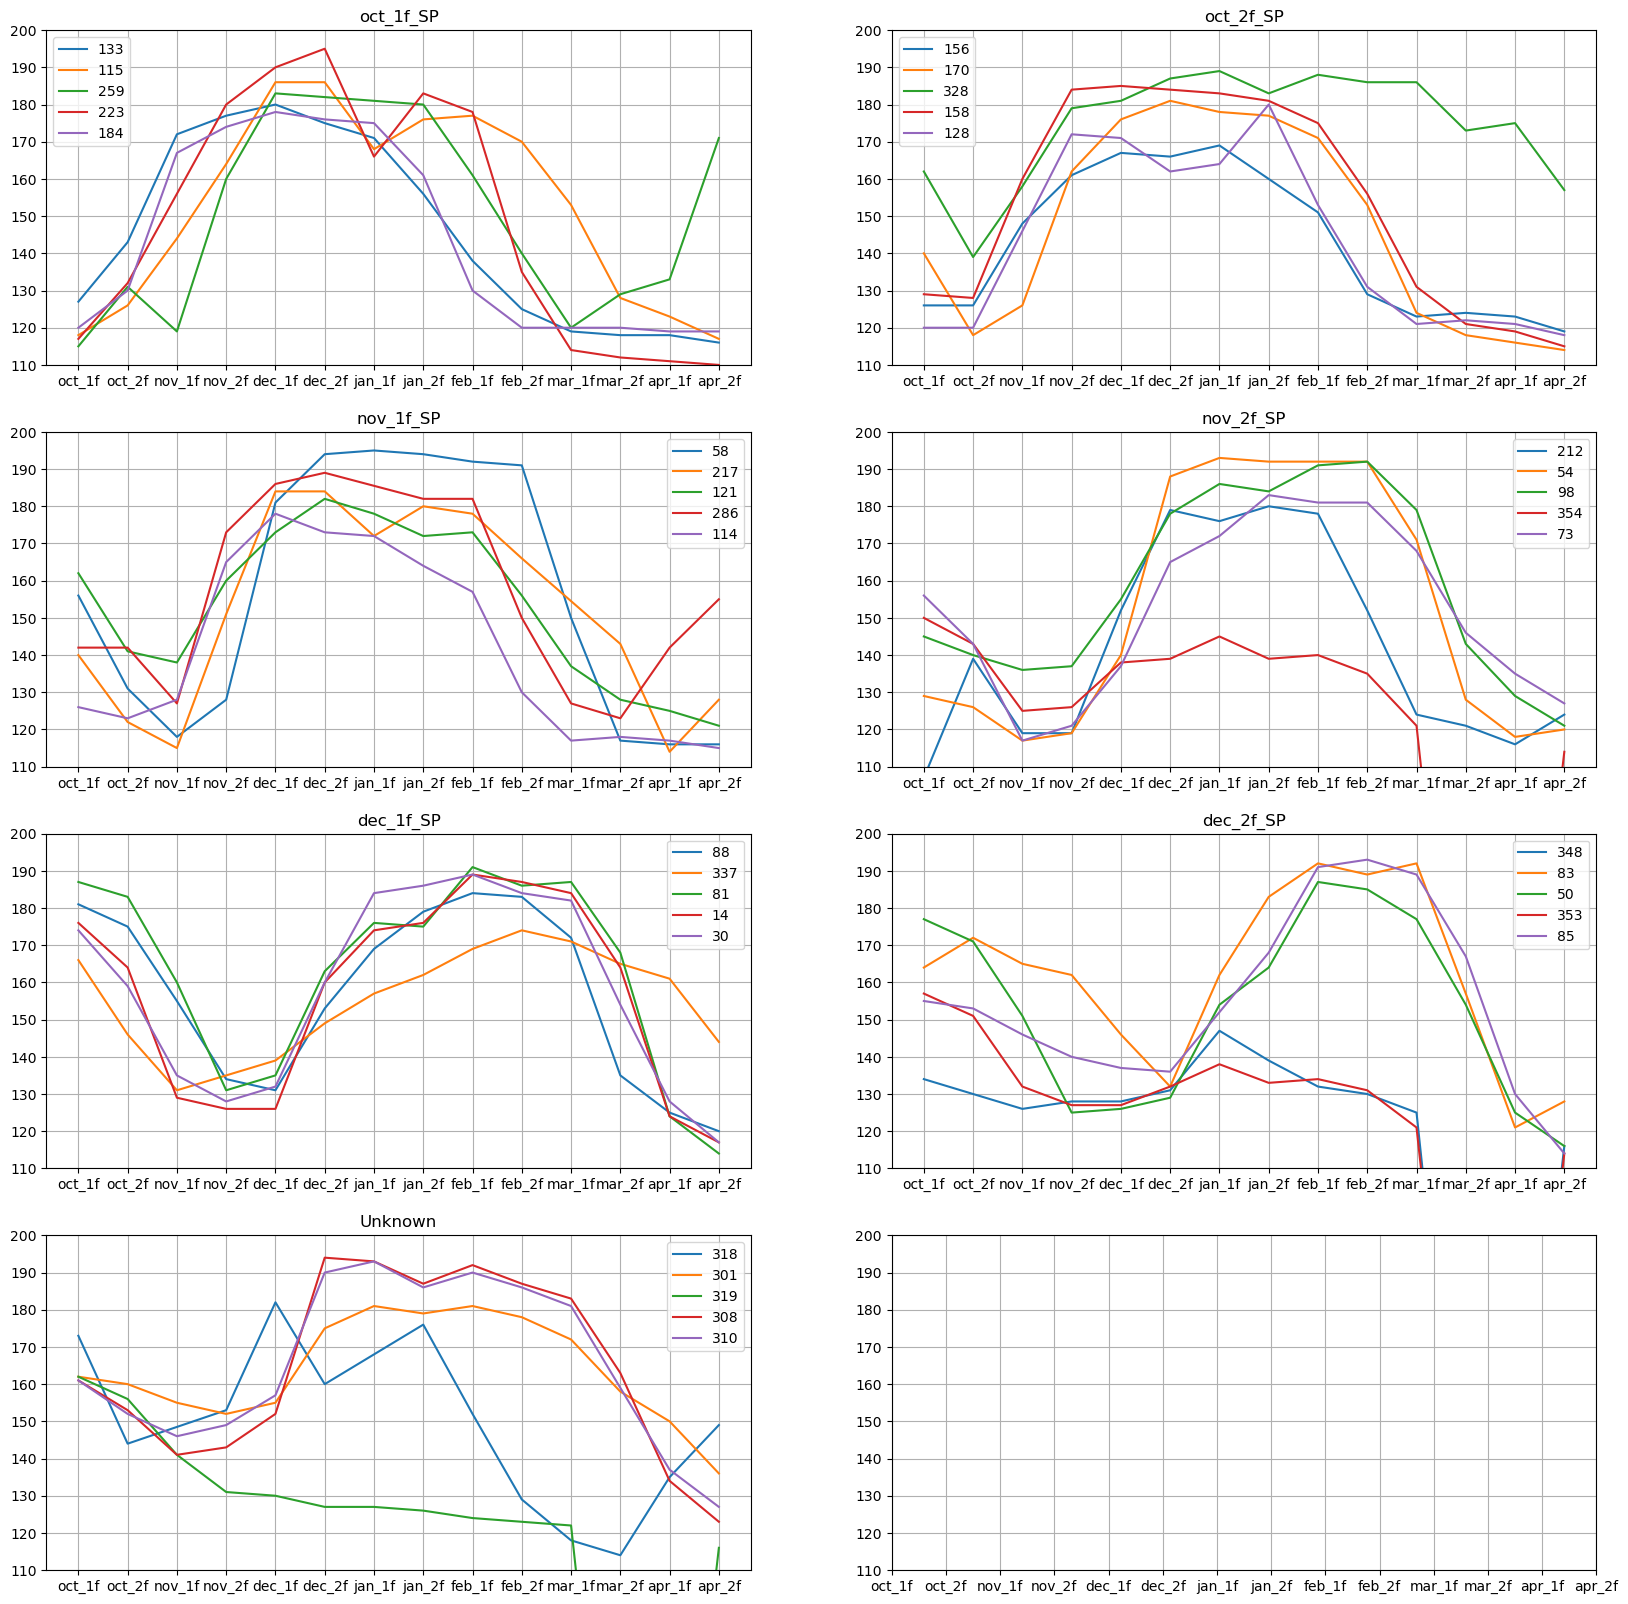

In [101]:
# Plotting signatures of both determined and undertermined sowing periods

plt.rcParams['axes.grid'] = True

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

plt.setp(axes,  xticks = np.arange(0,14,1), xticklabels = data.loc[:,'oct_1f':'apr_2f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

data[data.sowing_period == 'oct_1f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[0,0],
                                                                                         title='oct_1f_SP')
data[data.sowing_period == 'oct_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[0,1],
                                                                                         title='oct_2f_SP')
data[data.sowing_period == 'nov_1f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[1,0],
                                                                                         title='nov_1f_SP')
data[data.sowing_period == 'nov_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[1,1],
                                                                                         title='nov_2f_SP')
data[data.sowing_period == 'dec_1f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[2,0],
                                                                                         title='dec_1f_SP')
data[data.sowing_period == 'dec_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[2,1],
                                                                                         title='dec_2f_SP')
data[data.sowing_period == 'Unknown'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=0).T.plot(ax=axes[3,0],
                                                                                         title='Unknown')

plt.show()

- Data points (NDVI signatures) with undefined sowing periods are dropped, and they are categorized as non-crop.

In [102]:
# Dropping the Unknown sowing period labels

outliers = gp.GeoDataFrame() # initializing an empty dataframe to store outliers/non_crops
new_outliers = data[data.sowing_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

data.drop(new_outliers.index, inplace=True)

display(f'{new_outliers.shape[0]} dropped')

'20 dropped'

__Determination of Harvest__

- After identifying the sowing period, the initial NDVI value below 140, occurring six fortnights or three months after the sowing period, is considered as the first fortnight following harvest.

In [103]:
# Harvest period determination

def harvest_period(row):
    sowing_period_idx = row.index.get_loc(row['sowing_period'])
    i = sowing_period_idx + 6
    while i < len(row.loc[:'apr_2f']):
        if row.iloc[i] < 140:
            return row.index[i-1]
        i += 1
    return 'Unknown'

data['harvest_period'] = data.apply(harvest_period, axis=1)

data.harvest_period.value_counts()

feb_2f     91
feb_1f     82
mar_1f     76
mar_2f     51
Unknown    20
jan_2f     15
apr_1f      3
jan_1f      2
Name: harvest_period, dtype: int64

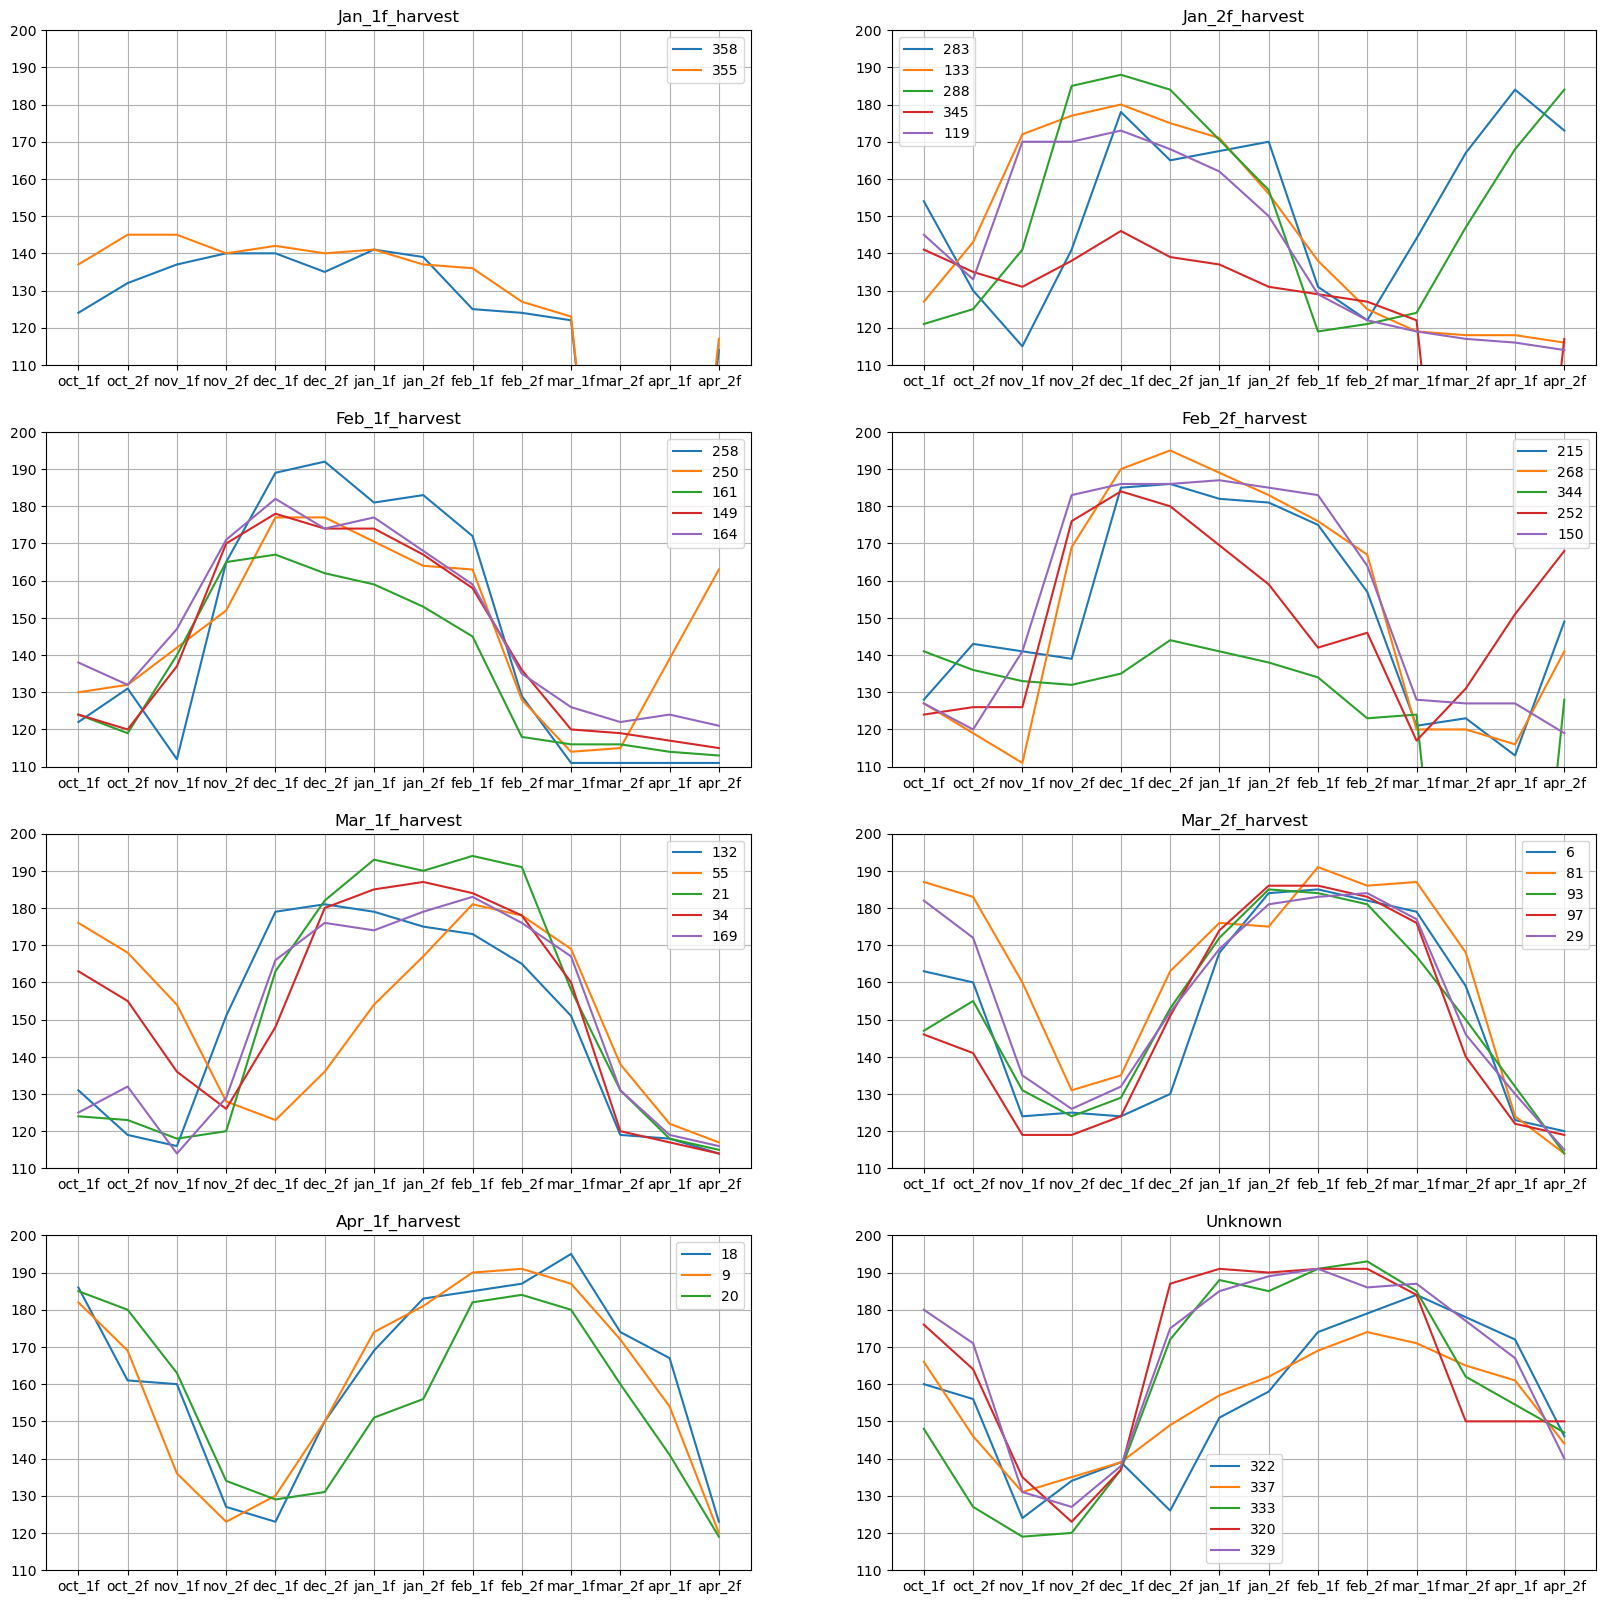

In [104]:
# Plotting signatures of both determined and undertermined harvest periods

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

plt.setp(axes,  xticks = np.arange(0,14,1), xticklabels = data.loc[:,'oct_1f':'apr_2f'].columns,
         yticks=np.arange(60,220,10), ylim=[110,200])

data[data.harvest_period == 'jan_1f'].loc[:,'oct_1f':'apr_2f'].sample(2, random_state=190).T.plot(ax=axes[0,0],
                                                                                         title='Jan_1f_harvest')
data[data.harvest_period == 'jan_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[0,1],
                                                                                         title='Jan_2f_harvest')
data[data.harvest_period == 'feb_1f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[1,0],
                                                                                         title='Feb_1f_harvest')
data[data.harvest_period == 'feb_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[1,1],
                                                                                         title='Feb_2f_harvest')
data[data.harvest_period == 'mar_1f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[2,0],
                                                                                         title='Mar_1f_harvest')
data[data.harvest_period == 'mar_2f'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[2,1],
                                                                                         title='Mar_2f_harvest')
data[data.harvest_period == 'apr_1f'].loc[:,'oct_1f':'apr_2f'].sample(3, random_state=190).T.plot(ax=axes[3,0],
                                                                                         title='Apr_1f_harvest')
data[data.harvest_period == 'Unknown'].loc[:,'oct_1f':'apr_2f'].sample(5, random_state=190).T.plot(ax=axes[3,1],
                                                                                         title='Unknown')

plt.show()

- Data points (NDVI signatures) with undefined harvest periods are dropped, and they are categorized as non-crop.

In [105]:
# Dropping the Unknown harvest labels

new_outliers = data[data.harvest_period == 'Unknown']
outliers = pd.concat([outliers, new_outliers])

data.drop(new_outliers.index, inplace=True)

__NDVI of 150 rule__

- Following the sowing period, the NDVI values must reach a minimum of 150 at least once; otherwise, the observed pattern is not indicative of a crop.

'20 dropped'

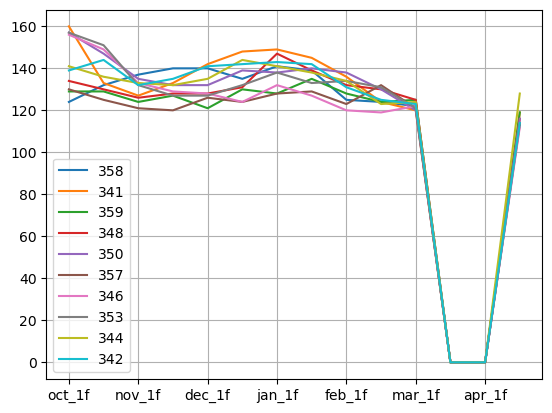

In [106]:
def less_than_150_drop(row):
    sp_loc = row.index.get_loc(row['sowing_period'])
    hp_loc = row.index.get_loc(row['harvest_period'])
    if max(row.iloc[sp_loc+1:hp_loc]) < 150:
        return False
    return True

## Checking if there are rows which have max of NDVI values less than 150 for all the values between sp and hp.

new_outliers = data[data.apply(less_than_150_drop, axis=1) == False]
outliers = pd.concat([outliers, new_outliers])

data = data.drop(new_outliers.index)

display(f'{new_outliers.shape[0]} dropped')

if new_outliers.shape[0] > 10:
    new_outliers.loc[:,'oct_1f':'apr_2f'].sample(10, random_state=0).T.plot()
else:
    new_outliers.loc[:,'oct_1f':'apr_2f'].T.plot()

plt.show()

In [107]:
# Dropping duplicates (if any)

data.drop_duplicates(inplace=True)

# File Export

In [108]:
data.to_csv(r'notebooks/demo/data_files/preprocessed_data_sample.csv', index=False)